In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np


import os
import cv2
import sys
import h5py
import time
import pickle
import tempfile
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display as ipy_display, clear_output

In [2]:
# setting path
sys.path.append('../')

In [3]:
deplabv3 = __import__('Deeplabv3')
import networks

In [4]:
dataset = __import__('dataset-step4')

# parameters

In [5]:
num_classes = 5
batch_size = 1
suffix = 'run4'
epoch = 126
epoch = str(epoch)

dataset_name = 'abdomen'

# CUDA

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

# Path

In [7]:
root = "/media/rs37890/d28c4aed-3c7e-4203-8590-f72f868ee829/rs37890/Medical_images_source_MR/data/data/"

In [8]:
source_mr_train_dir = root + "h5py/"
source_mr_test_dir = root + "h5py/"

In [9]:
target_ct_train_dir = root + "h5py/"
target_ct_test_dir = root + "h5py/"

# label_ids_abdomen

In [10]:
label_ids_abdomen = {"ignore": 0,
    "lv_myo": 1,
    "la_blood": 2,
    "lv_blood": 3,
    "aa": 4,
}
label_ids = label_ids_abdomen

# Dataset

In [11]:
def sample_batch(dataset, batch_size=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    data_dir = dataset.data_dir
    num_samples = len(dataset)
    sample_indices = np.random.choice(num_samples, batch_size, replace=False) # replace=True allow repeat

    images = []
    labels = []

    for idx in sample_indices:
        
        data_vol, label_vol = dataset[idx]
        
        images.append(data_vol)
        labels.append(label_vol)

    images = torch.stack(images)
    labels = torch.stack(labels)

    return images, labels

#  sliding_window

In [12]:
def sliding_window(input_volume, window_size=(32, 32, 32), stride=(16, 16, 16)):
    
    z_max = input_volume.shape[0] - window_size[0] + 1
    x_max = input_volume.shape[1] - window_size[1] + 1
    y_max = input_volume.shape[2] - window_size[2] + 1

    windows = []

    for y in range(0, y_max, stride[2]):
        for x in range(0, x_max, stride[1]):
            for z in range(0, z_max, stride[0]):
                window = input_volume[z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]]
                windows.append(window)

            # z_remaining
            z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            window = input_volume[z_remaining:, x:x+window_size[1], y:y+window_size[2]]
            windows.append(window)
        
        # x_remaining
        x_remaining = input_volume.shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
        for z in range(0, z_max, stride[0]):
            window = input_volume[z:z+window_size[0], x_remaining: , y:y+window_size[2]]
            windows.append(window)
            
        # x_remaining z_remaining
        z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        window = input_volume[z_remaining:, x_remaining: , y:y+window_size[2]]
        windows.append(window)
    
    # y_remaining
    y_remaining = input_volume.shape[2] - window_size[2] # z_remaining = 78 - 32 = 46
    for x in range(0, x_max, stride[1]):
        for z in range(0, z_max, stride[0]):
            window = input_volume[z:z+window_size[0], x:x+window_size[1], y_remaining: ]
            windows.append(window)
            
        # y_remaining z_remaining
        z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        window = input_volume[z_remaining:, x:x+window_size[1], y_remaining:]
        windows.append(window)

    # y_remaining x_remaining
    x_remaining = input_volume.shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
    for z in range(0, z_max, stride[0]):
        window = input_volume[z:z+window_size[0], x_remaining: , y_remaining:]
        windows.append(window)

    # y_remaining x_remaining z_remaining
    z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
    window = input_volume[z_remaining:, x_remaining: , y_remaining:]
    windows.append(window)

    return windows

In [13]:
def combine_windows(window_outputs, input_volume_shape, window_size=(32, 32, 32), stride=(16, 16, 16)):
    num_classes = window_outputs[0].shape[1] # 5
    combined_prob = torch.zeros((num_classes,) + input_volume_shape).to(device)
    count_matrix = torch.zeros(input_volume_shape).to(device)

    z_max = input_volume_shape[0] - window_size[0] + 1
    x_max = input_volume_shape[1] - window_size[1] + 1
    y_max = input_volume_shape[2] - window_size[2] + 1

    idx = 0
    
    
    for y in range(0, y_max, stride[2]):
        for x in range(0, x_max, stride[1]):
            for z in range(0, z_max, stride[0]):
                output = window_outputs[idx].squeeze() # output.cpu().numpy().shape: (5, 32, 256, 256)
                combined_prob[:, z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]] += output
                count_matrix[z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]] += 1
                idx += 1
                

            # z_remaining
            z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            output = window_outputs[idx].squeeze()
            combined_prob[:, z_remaining:, x:x+window_size[1], y:y+window_size[2]] += output
            count_matrix[z_remaining:, x:x+window_size[1], y:y+window_size[2]] += 1
            idx += 1
        
        # x_remaining
        x_remaining = input_volume_shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
        for z in range(0, z_max, stride[0]):
            output = window_outputs[idx].squeeze()
            combined_prob[:, z:z+window_size[0], x_remaining: , y:y+window_size[2]] += output
            count_matrix[z:z+window_size[0], x_remaining: , y:y+window_size[2]] += 1
            idx += 1
            
            
        # x_remaining z_remaining
        z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        output = window_outputs[idx].squeeze()
        combined_prob[:, z_remaining:, x_remaining: , y:y+window_size[2]] += output
        count_matrix[z_remaining:, x_remaining: , y:y+window_size[2]] += 1
        idx += 1
        
    
    # y_remaining
    y_remaining = input_volume_shape[2] - window_size[2] # z_remaining = 78 - 32 = 46
    for x in range(0, x_max, stride[1]):
        for z in range(0, z_max, stride[0]):
            output = window_outputs[idx].squeeze()
            combined_prob[:, z:z+window_size[0], x:x+window_size[1], y_remaining: ] += output
            count_matrix[z:z+window_size[0], x:x+window_size[1], y_remaining: ] += 1
            idx += 1
            
            
        # y_remaining z_remaining
        z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        output = window_outputs[idx].squeeze()
        combined_prob[:, z_remaining:, x:x+window_size[1], y_remaining:] += output
        count_matrix[z_remaining:, x:x+window_size[1], y_remaining:] += 1
        idx += 1
        

    # y_remaining x_remaining
    x_remaining = input_volume_shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
    for z in range(0, z_max, stride[0]):
        output = window_outputs[idx].squeeze()
        combined_prob[:, z:z+window_size[0], x_remaining: , y_remaining:] += output
        count_matrix[z:z+window_size[0], x_remaining: , y_remaining:] += 1
        idx += 1

    # y_remaining x_remaining z_remaining
    z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
    output = window_outputs[idx].squeeze()
    combined_prob[:, z_remaining:, x_remaining: , y_remaining:] += output
    count_matrix[z_remaining:, x_remaining: , y_remaining:] += 1
    idx += 1
    
    
    # Normalize the class probabilities
    combined_prob /= count_matrix

    # Take the argmax of the accumulated probabilities
    combined_output = torch.argmax(combined_prob, dim=0)

    return combined_output

# Initialize

In [14]:
dataloader = dataset.get_dataloader( target_ct_train_dir,  target_ct_test_dir, num_classes, batch_size,  domain = 'target' )

train_dataset = dataloader["train"].dataset
#test_dataset = train_dataset
test_dataset = dataloader["test"].dataset

In [15]:
dpv3 = deplabv3.DeepLabV3(num_classes)
classifier = networks.classifier(num_classes)

dpv3 = dpv3.to(device)
classifier = classifier.to(device)

# parallel
dpv3 = torch.nn.DataParallel(dpv3)
classifier = torch.nn.DataParallel(classifier)

In [16]:
dpv3_checkpoint = torch.load('/media/rs37890/d28c4aed-3c7e-4203-8590-f72f868ee829/rs37890/Medical_images_source_MR/Deeplabv3_source_MR/record-data/dpv3_weights_20000.pth')
classifier_checkpoint = torch.load('/media/rs37890/d28c4aed-3c7e-4203-8590-f72f868ee829/rs37890/Medical_images_source_MR/Deeplabv3_source_MR/record-data/classifier_weights_20000.pth')

dpv3.load_state_dict(dpv3_checkpoint)
classifier.load_state_dict(classifier_checkpoint)
print("continue_run")
print("Loaded model weights")

continue_run
Loaded model weights


In [17]:
dpv3 = dpv3.module
classifier = classifier.module

In [18]:
with open('Adaptation-record-data/' + "loss_history"  + ".pkl", "rb") as file:
    loss_history = pickle.load(file)
    
print(len(loss_history))

155


# Show results

In [19]:
test_output = []

for img_idx in range(len(test_dataset)): # 0, 1, 2, 3
    
    data_vol, label_vol = test_dataset[img_idx] # data_vol: torch.Size([1, 60, 512, 512])
    data_vol = data_vol.to(device)
    label_vol = label_vol.to(device)
    
    data_vol = torch.squeeze(data_vol, 0) # data_vol:  torch.Size([60, 512, 512])
    windows = sliding_window(data_vol) # slice 3D image based on window size and stride
    
    
    
    window_outputs = []
    
    dpv3.eval()
    classifier.eval() 
    with torch.no_grad():
        for window in windows:
            window = window.unsqueeze(0)  # Add a channel dimension: torch.Size([1, 32, 256, 256])
            window = torch.unsqueeze(window, 0)  # Add a batch dimension: torch.Size([1, 1, 32, 256, 256])
            
            # inference
            output = dpv3(window)
            output = classifier(output) # torch.Size([1, 5, 32, 256, 256])
            
            # collect outputs
            window_outputs.append(output)  # len(window_outputs) = 27
            # window_outputs[0].cpu().numpy().shape： (1, 5, 32, 256, 256)

    combined_output = combine_windows(window_outputs, data_vol.size())
    test_output.append(combined_output)

# evaluate

In [20]:
numpy_arrays = [tensor.cpu().numpy() for tensor in test_output]

In [21]:
numpy_arrays[0].shape

(99, 102, 104)

In [22]:
numpy_arrays[1].shape

(109, 121, 84)

In [23]:
numpy_arrays[2].shape

(159, 87, 86)

In [24]:
numpy_arrays[3].shape

(124, 101, 117)

In [25]:
id_to_ignore = 0
intersection = dict()
total = dict()
for label in label_ids:
    intersection[label] = total[label] = 0



for img_idx in range(len(test_dataset)): # 0, 1, 2, 3

    if img_idx != 2:
        continue
    
    data_sample, y_true = test_dataset[img_idx] # data_vol: torch.Size([1, 60, 512, 512])
    
    y_hat = numpy_arrays[img_idx]
    data_sample = data_sample.cpu().numpy() 
    y_true = y_true.cpu().numpy() 
    
    print(y_hat.shape)
    print(y_true.shape)
    
    for label in label_ids:
        if label_ids[label] == id_to_ignore:
            continue

        curr_id = label_ids[label]

        idx_gt = y_true == curr_id
        idx_hat = y_hat == curr_id

        intersection[label] += 2 * np.sum(idx_gt & idx_hat)
        total[label] += np.sum(idx_gt) + np.sum(idx_hat)
        
        
dice = []
res = dict()
for label in label_ids:
    if label_ids[label] == id_to_ignore:
        continue

    if total[label] != 0:
        res[label] = intersection[label] / total[label]
    else:
        print('total is zero')
        res[label] = np.float64(0)

    dice.append(res[label])

(159, 87, 86)
(159, 87, 86)


In [26]:
np.mean(dice)

0.683676273256177

In [27]:
for k in res:
    print(k, res[k])

lv_myo 0.198850956744694
la_blood 0.881640114089412
lv_blood 0.7754417756081926
aa 0.878772246582409


In [28]:
img_idx = 3

In [29]:
data_sample = data_sample[0]

In [30]:
data_sample[:32,:32,:32].shape

(32, 32, 32)

In [31]:
data_sample = data_sample[:32,:32,:32]

In [32]:
# Check if the data_sample is empty or not
if data_sample.size == 0:
    print("The 3D volume is empty. Check your data.")
else:
    print(f"Shape: {data_sample.shape}, Data Type: {data_sample.dtype}")

    # Normalize the data if necessary
    if data_sample.dtype != np.uint8:
        data_sample = (255 * (data_sample - data_sample.min()) / (data_sample.max() - data_sample.min())).astype(np.uint8)

    # Prepare the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Generate the 3D coordinates
    x, y, z = np.indices(data_sample.shape)

    # Flatten the arrays and filter the non-zero values
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = data_sample.flatten()

    # Filter out zero values for better visualization
    non_zero = values > 0
    x = x[non_zero]
    y = y[non_zero]
    z = z[non_zero]
    values = values[non_zero]

    # Create a scatter plot
    ax.scatter(x, y, z, c=values, cmap='gray', marker='o')

    # Remove axis
    ax.set_axis_off()

    # Save the plot as an image
    plt.savefig('3D_volume_target_crop.png', bbox_inches='tight', pad_inches=0)

    # Close the plot to avoid displaying it
    plt.close()

Shape: (32, 32, 32), Data Type: float32


# y_true

In [33]:
y_true.shape

(159, 87, 86)

In [34]:
y_true_crop = y_true[
    y_true.shape[0] // 2 - 0 : y_true.shape[0] // 2 + 32,
    y_true.shape[1] // 2 - 0 : y_true.shape[1] // 2 + 32,
    y_true.shape[2] // 2 - 0 : y_true.shape[2] // 2 + 32
]


Shape: (32, 32, 32), Data Type: int64


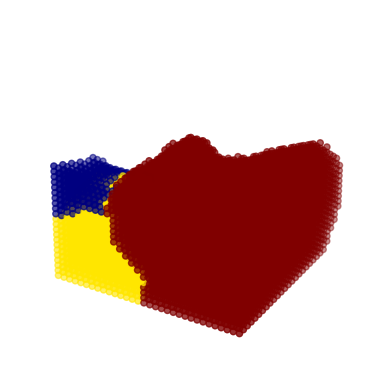

In [35]:
# Check if the data_sample is empty or not
if y_true_crop.size == 0:
    print("The 3D volume is empty. Check your data.")
else:
    print(f"Shape: {y_true_crop.shape}, Data Type: {y_true_crop.dtype}")

    # Normalize the data if necessary
    if y_true_crop.dtype != np.uint8:
        y_true_crop = (255 * (y_true_crop - y_true_crop.min()) / (y_true_crop.max() - y_true_crop.min())).astype(np.uint8)

    # Prepare the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Generate the 3D coordinates
    x, y, z = np.indices(y_true_crop.shape)

    # Flatten the arrays and filter the non-zero values
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = y_true_crop.flatten()

    # Filter out zero values for better visualization
    non_zero = values > 0
    x = x[non_zero]
    y = y[non_zero]
    z = z[non_zero]
    values = values[non_zero]

    # Create a scatter plot
    ax.scatter(x, y, z, c=values, cmap='jet', marker='o')

    # Remove axis
    ax.set_axis_off()

    # Save the plot as an image
    # plt.savefig('3D_label_target_crop.png', bbox_inches='tight', pad_inches=0)

    # Close the plot to avoid displaying it
    # plt.close()

In [39]:
len(y_true_crop)

32

In [40]:
type(y_true_crop)

numpy.ndarray

In [41]:
y_true_crop.shape

(32, 32, 32)

In [47]:
from scipy.ndimage import laplace, sobel, binary_dilation

Shape: (32, 32, 32), Data Type: uint8


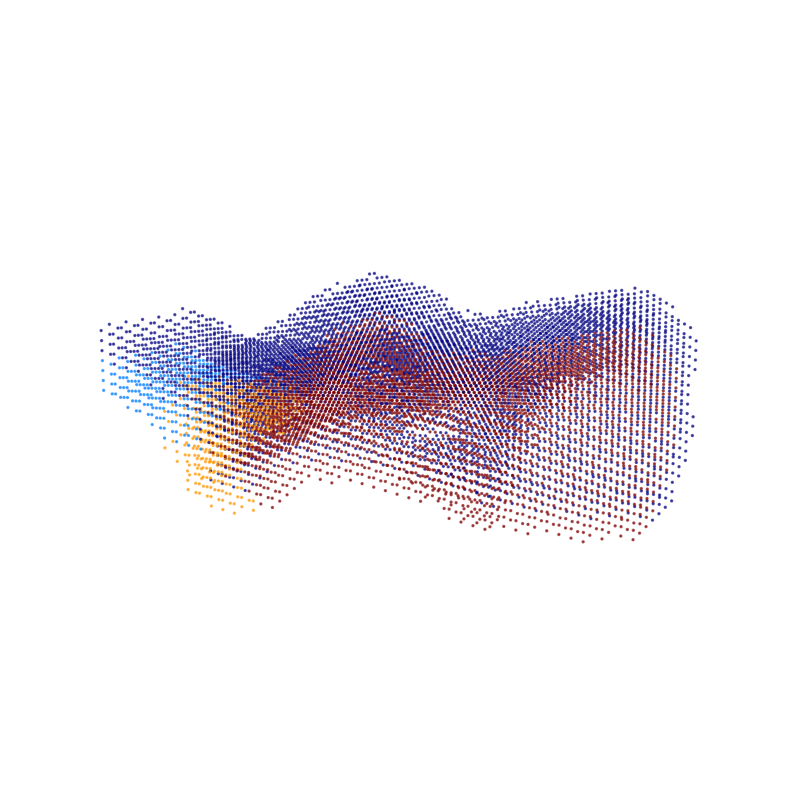

In [48]:
if y_true_crop.size == 0:
    print("The 3D volume is empty. Check your data.")
else:
    print(f"Shape: {y_true_crop.shape}, Data Type: {y_true_crop.dtype}")

    # Normalize the data if necessary
    if y_true_crop.dtype != np.uint8:
        y_true_crop = (255 * (y_true_crop - y_true_crop.min()) / (y_true_crop.max() - y_true_crop.min())).astype(np.uint8)

    # Use Sobel filter to detect edges
    edges_x = sobel(y_true_crop, axis=0)
    edges_y = sobel(y_true_crop, axis=1)
    edges_z = sobel(y_true_crop, axis=2)

    # Combine edges
    edges = np.sqrt(edges_x**2 + edges_y**2 + edges_z**2)

    # Threshold to create a binary edge map
    edge_map = edges > 0  # Adjust this threshold if needed

    # Dilate the edges to include nearby areas
    dilated_edges = binary_dilation(edge_map, iterations=2)  # Increase iterations for wider edges

    # Prepare the 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate the 3D coordinates
    x, y, z = np.indices(y_true_crop.shape)

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    dilated_edge_values = dilated_edges.flatten()
    original_values = y_true_crop.flatten()

    # Filter out non-edge values for visualization
    edge_points = dilated_edge_values > 0
    x = x[edge_points]
    y = y[edge_points]
    z = z[edge_points]
    colors = original_values[edge_points]  # Use original values for coloring

    # Create a scatter plot for edges with nearby colors
    ax.scatter(x, y, z, c=colors, cmap='jet', marker='o', s=2, alpha=0.6)

    # Remove axis
    ax.set_axis_off()

    # Show plot
    plt.show()